In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed.
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# StellarGraph library need to be installed in the environment
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph.utils import plot_history
from tensorflow import keras

In [2]:
# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory;
import datetime
import random 
import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output;
print(os.getcwd())

['ppi_v.csv', 'ppi_e.csv', 'ppi_predictions.csv', 'ppi_e_train.csv', 'ppi_e_test.csv']
/Users/gweedo/Desktop/NECSTLab/Oracle/Corso Oracle/Fall 2021/high-performance-graph-analytics-2021/graph_ml


In [3]:
# A list of utility functions used below to manipulate/clean data and compute accuracy metrics;

def build_dataframe(input_data: pd.DataFrame, col_name: str, preserve_int_col_name=False) -> pd.DataFrame:
    """
    Given an input DataFrame and a column name, return a new DataFrame in which the column has been cleaned.
    Used to transform features and labels columns from "0;1;1;0" to [0, 1, 1, 0]
    """
    vertices_dict = []
    for i, row_i in input_data.iterrows():
        features = [int(float(x)) for x in row_i[f"{col_name}s"].split(";")]
        
        new_v = {"id": i}
        for j, f in enumerate(features):
            new_v[j if preserve_int_col_name else f"{col_name}_{j}"] = f
        vertices_dict += [new_v]
    res_df = pd.DataFrame(vertices_dict)
    return res_df.set_index("id")

def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+keras.backend.epsilon())
    return f1_val

In [4]:
# graph_name = "ppi"

# # Read vertex data
# vertices_path = f"./input/{graph_name}_v.csv"
# vertices = pd.read_csv(vertices_path, sep=",", index_col="id")
# vertices.drop(['dataset'], axis=1, inplace=True)
# vertices = build_dataframe(vertices, "feature")

# # Read edges data
# edge_path = f"./input/{graph_name}_e.csv"
# edges = pd.read_csv(edge_path, sep=",", index_col=None)

# # Build graph from dataframes
# ppi_graph = StellarGraph(nodes={'protein':vertices}, edges={'interaction':edges}, source_column="source", target_column="dest")
# print(ppi_graph.info())

# # Split train/test set, save them as separate files
# edge_splitter_test = EdgeSplitter(ppi_graph)
# graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
#     p=0.1, method="global", keep_connected=True, seed=0
# )

# test_sources = [examples_test[i][0] for i in range(0,len(examples_test))]
# test_dests = [examples_test[i][1] for i in range(0,len(examples_test))]
# test_df = pd.DataFrame(list(zip(test_sources, test_dests, labels_test)), columns=['source', 'dest', 'label'])

# NegPosRatio = 3
# for iter in range(1,NegPosRatio):
#     graph_tmp, examples_tmp, labels_tmp = edge_splitter_test.train_test_split(
#         p=0.1, method="global", keep_connected=True, seed=iter
#     )
#     tmp_sources = [examples_tmp[i][0] for i in range(len(examples_tmp)//2,len(examples_tmp))]
#     tmp_dests = [examples_tmp[i][1] for i in range(len(examples_tmp)//2,len(examples_tmp))]
#     tmp_df = pd.DataFrame(list(zip(tmp_sources, tmp_dests, labels_tmp[len(examples_tmp)//2:])), columns=['source', 'dest', 'label'])
#     test_df = pd.concat([test_df, tmp_df])

# test_df.to_csv(f"./input/{graph_name}_e_test.csv", index=False)
# visible_edges = pd.DataFrame(graph_test.edges(), columns=['source', 'dest'])
# visible_edges.to_csv(f"./input/{graph_name}_e_train.csv", index=False)

In [5]:
# Define graph name
graph_name = "ppi"

# Read vertex data
vertices_path = f"./input/{graph_name}_v.csv"
vertices = pd.read_csv(vertices_path, sep=",", index_col="id")
vertices.drop(['dataset'], axis=1, inplace=True)
vertices = build_dataframe(vertices, "feature")
vertices.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Read edges data (complete graph)
edge_path = f"./input/{graph_name}_e.csv"
edges = pd.read_csv(edge_path, sep=",", index_col=None)
edges.head()

,source,dest
0,0,372
1,0,1101
2,0,766
3,1,640
4,1,1


In [7]:
# Read edges data (training data)
edge_path = f"./input/{graph_name}_e_train.csv"
edges_train = pd.read_csv(edge_path, sep=",", index_col=None)
edges_train.head()

,source,dest
0,0,372
1,0,1101
2,0,766
3,1,640
4,1,1


In [8]:
# Read edges data (test data)
edge_path = f"./input/{graph_name}_e_test.csv"
edges_test = pd.read_csv(edge_path, sep=",", index_col=None)
edges_test.tail()

,source,dest,label
327479,30563,16872,0
327480,7213,30761,0
327481,46231,23301,0
327482,34020,7662,0
327483,43043,25230,0


In [9]:
# Extract numpy arrays for test examples and respective labels
examples_test = edges_test.drop(['label'], axis=1).to_numpy()
labels_test = edges_test['label'].to_numpy()

In [10]:
# Build complete graph from vertices and edges dataframes
ppi_graph = StellarGraph(nodes={'protein':vertices}, edges={'interaction':edges}, source_column="source", target_column="dest")
print(ppi_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 56944, Edges: 818716

 Node types:
  protein: [56944]
    Features: float32 vector, length 50
    Edge types: protein-interaction->protein

 Edge types:
    protein-interaction->protein: [818716]
        Weights: all 1 (default)
        Features: none


In [11]:
# Build test graph from vertices and edges dataframes
graph_test = StellarGraph(nodes={'protein':vertices}, edges={'interaction':edges_train}, source_column="source", target_column="dest")
print(graph_test.info())

StellarGraph: Undirected multigraph
 Nodes: 56944, Edges: 736845

 Node types:
  protein: [56944]
    Features: float32 vector, length 50
    Edge types: protein-interaction->protein

 Edge types:
    protein-interaction->protein: [736845]
        Weights: all 1 (default)
        Features: none


In [12]:
# Split training data in train/validation set
edge_splitter_train = EdgeSplitter(graph_test, ppi_graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)
print(graph_train.info())

** Sampled 73684 positive and 73684 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 56944, Edges: 663161

 Node types:
  protein: [56944]
    Features: float32 vector, length 50
    Edge types: protein-interaction->protein

 Edge types:
    protein-interaction->protein: [663161]
        Weights: all 1 (default)
        Features: none


In [13]:
# Build training dataframe for explicit visualization
train_sources = [examples[i][0] for i in range(0,len(examples))]
train_dests = [examples[i][1] for i in range(0,len(examples))]
train_df = pd.DataFrame(list(zip(train_sources, train_dests, labels)), columns=['source', 'dest', 'label'])
print(train_df)

        source   dest  label
0        31536  32585      1
1        18183  18405      1
2         5684   6869      1
3         7882   8801      1
4        31048  32230      1
...        ...    ...    ...
147363   49712  52640      0
147364   35515  42269      0
147365   37297   5947      0
147366   18770  19197      0
147367   33139  28863      0

[147368 rows x 3 columns]


In [14]:
epochs = 50

# controllare come indicare modelli custom -> cosa fa la variabile method?
train_gen = FullBatchLinkGenerator(graph_train, method="gcn")
train_flow = train_gen.flow(examples, labels)

test_gen = FullBatchLinkGenerator(graph_test, method="gcn")
test_flow = test_gen.flow(examples_test, labels_test)


Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [15]:
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

x_inp, x_out = gcn.in_out_tensors()

prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.BinaryAccuracy(), F1_Score],
)

In [16]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 385ms/step - loss: 1.0480 - binary_accuracy: 0.7500 - F1_Score: 1.2214e-04

Train Set Metrics of the initial (untrained) model:
	loss: 2.0791
	binary_accuracy: 0.5000
	F1_Score: 0.0000

Test Set Metrics of the initial (untrained) model:
	loss: 1.0480
	binary_accuracy: 0.7500
	F1_Score: 0.0001


In [17]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 2.0517 - binary_accuracy: 0.5000 - F1_Score: 8.1424e-05 - val_loss: 0.6782 - val_binary_accuracy: 0.7500 - val_F1_Score: 5.3721e-04
Epoch 2/50
1/1 - 1s - loss: 1.2885 - binary_accuracy: 0.5002 - F1_Score: 0.0010 - val_loss: 0.4858 - val_binary_accuracy: 0.7619 - val_F1_Score: 0.1037
Epoch 3/50
1/1 - 1s - loss: 0.8359 - binary_accuracy: 0.5290 - F1_Score: 0.1155 - val_loss: 0.4683 - val_binary_accuracy: 0.8176 - val_F1_Score: 0.5465
Epoch 4/50
1/1 - 1s - loss: 0.5828 - binary_accuracy: 0.6925 - F1_Score: 0.5937 - val_loss: 0.9570 - val_binary_accuracy: 0.7301 - val_F1_Score: 0.6039
Epoch 5/50
1/1 - 1s - loss: 0.7833 - binary_accuracy: 0.7542 - F1_Score: 0.7707 - val_loss: 1.2131 - val_binary_accuracy: 0.6809 - val_F1_Score: 0.5775
Epoch 6/50
1/1 - 1s - loss: 0.9501 - binary_accuracy: 0.7347 - F1_Score: 0.7677 - val_loss: 1.0309 - val_binary_accuracy: 0.7161 - val_F1_Score: 0.5963
Epoch 7/50
1/1 - 1s - loss: 0.8415 - binary_accuracy: 0.7492 - F1_Score: 0.7716 

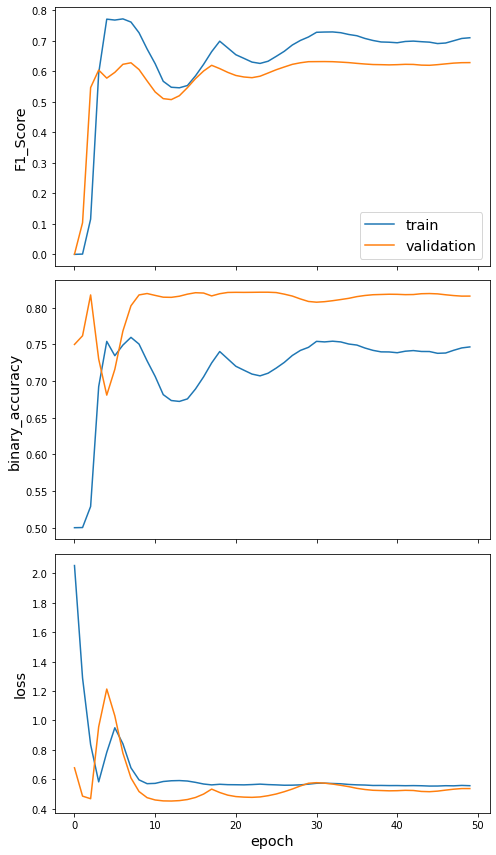

In [18]:
plot_history(history)

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 289ms/step - loss: 0.5372 - binary_accuracy: 0.8160 - F1_Score: 0.6283

Train Set Metrics of the trained model:
	loss: 0.5508
	binary_accuracy: 0.7493
	F1_Score: 0.7120

Test Set Metrics of the trained model:
	loss: 0.5372
	binary_accuracy: 0.8160
	F1_Score: 0.6283


In [20]:
y_pred = model.predict(test_flow)
y_pred = keras.backend.round(keras.backend.clip(y_pred, 0, 1)).numpy()
y_pred_df = pd.DataFrame(np.transpose(y_pred), columns=['prediction'])
output = pd.concat([edges_test, y_pred_df], axis=1)
output.to_csv(f"./input/{graph_name}_predictions.csv", index=False)

In [21]:
prediction = pd.read_csv(f"./input/{graph_name}_predictions.csv", index_col=None)
print(F1_Score(np.array(output['label'], dtype=np.float32),np.array(output['prediction'], dtype=np.float32)))

tf.Tensor(0.6283094, shape=(), dtype=float32)
